In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
datadir="/export/data/dataset/media/"

In [2]:
import sys
import argparse
import os.path
import random
import time
import datetime
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
# from visdom import Visdom

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
img_size=256  # 256とします．
food = "omurice"
fooddir = "foodimg"+str(img_size)+"/"+food 

epochs = 60
batch_size= 64

outdir='out/pix2pix'
os.makedirs(outdir, exist_ok=True)

In [4]:
import glob
# 条件画像と正解画像のペアデータセット生成クラス
class AlignedDataset(Dataset):
    IMG_EXTENSIONS = ['.png', 'jpg']
    # configは全ての学習条件を格納する

    # 画像データは'/path/to/data/train'および'/path/to/data/test'に
    # {A,B}の形式で格納されているものとみなす

    def __init__(self, config):
        # データセットクラスの初期化
        self.config = config

        # 画像データパスの取得
        self.A_paths = [str(p) for p in glob.glob(datadir+fooddir+"/img*.jpg")]
        self.B_paths = [p.replace("/img","/hed").replace(".jpg",".png") for p in self.A_paths]
        
        print(len(self.B_paths))
        print(datadir+fooddir)

    def __transform(self, param):
        list = []

        load_size = self.config.load_size

        # 入力画像を一度286x286にリサイズし、その後で256x256にランダムcropする
        list.append(transforms.Resize([load_size, load_size], Image.BICUBIC))

        (x, y) = param['crop_pos']
        crop_size = self.config.crop_size
        list.append(transforms.Lambda(lambda img: img.crop((x, y, x + crop_size, y + crop_size))))

        # 1/2の確率で左右反転する
        if param['flip']:
            list.append(transforms.Lambda(lambda img: img.transpose(Image.FLIP_LEFT_RIGHT)))

        # RGB画像をmean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)にNormalizeする
        list += [transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

        return transforms.Compose(list)

    def __transform_param(self):
        x_max = self.config.load_size - self.config.crop_size
        x = random.randint(0, np.maximum(0, x_max))
        y = random.randint(0, np.maximum(0, x_max))

        flip = random.random() > 0.5

        return {'crop_pos': (x, y), 'flip': flip}

    def __getitem__(self, index):
        # 学習用データ１つの生成
        # A(テンソル) : 条件画像
        # B(テンソル) : Aのペアとなるターゲット画像

        # ランダムなindexの画像を取得 
        A_path = self.A_paths[index]
        A = Image.open(A_path).convert('RGB')
        B_path = self.B_paths[index]
        B = Image.open(B_path).convert('RGB')

        # 画像を2分割してAとBをそれぞれ取得
        # ランダムシードの生成
        param = self.__transform_param()
        w, h = A.size
        w2 = int(w / 2)
        # 256x256サイズの画像生成
        # 一度リサイズしてランダムな位置で256x256にcropする
        # AとBは同じ位置からcropする
        transform = self.__transform(param)
        #A = transform(AB.crop((0, 0, w2, h)))
        #B = transform(AB.crop((w2, 0, w, h)))
        A=transform(A)
        B=transform(B)
        
        #return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}
        return {'A': B, 'B': A, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        # 全画像ファイル数を返す
        return len(self.A_paths)

In [5]:
# 生成器Gのクラス定義
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # U-NetのEocoder部分
        self.down0 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.down1 = self.__encoder_block(64, 128)
        self.down2 = self.__encoder_block(128, 256)
        self.down3 = self.__encoder_block(256, 512)
        self.down4 = self.__encoder_block(512, 512)
        self.down5 = self.__encoder_block(512, 512)
        self.down6 = self.__encoder_block(512, 512)
        self.down7 = self.__encoder_block(512, 512, use_norm=False)
        # U-NetのDecoder部分
        self.up7 = self.__decoder_block(512, 512)
        self.up6 = self.__decoder_block(1024, 512, use_dropout=True)
        self.up5 = self.__decoder_block(1024, 512, use_dropout=True)
        self.up4 = self.__decoder_block(1024, 512, use_dropout=True)
        self.up3 = self.__decoder_block(1024, 256)
        self.up2 = self.__decoder_block(512, 128)
        self.up1 = self.__decoder_block(256, 64)
        # Gの最終出力
        self.up0 = nn.Sequential(
            self.__decoder_block(128, 3, use_norm=False),
            nn.Tanh(),
        )

    def __encoder_block(self, input, output, use_norm=True):
        # LeakyReLU＋Downsampling
        layer = [
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(input, output, kernel_size=4, stride=2, padding=1)
        ]
        # BatchNormalization
        if use_norm:
            layer.append(nn.BatchNorm2d(output))
        return nn.Sequential(*layer)

    def __decoder_block(self, input, output, use_norm=True, use_dropout=False):
        # ReLU＋Upsampling
        layer = [
            nn.ReLU(True),
            nn.ConvTranspose2d(input, output, kernel_size=4, stride=2, padding=1)
        ]
        # BachNormalization
        if use_norm:
            layer.append(nn.BatchNorm2d(output))
        # Dropout
        if use_dropout:
            layer.append(nn.Dropout(0.5))
        return nn.Sequential(*layer)

    def forward(self, x):
        # 偽物画像の生成
        x0 = self.down0(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)
        x7 = self.down7(x6)
        y7 = self.up7(x7)
        # Encoderの出力をDecoderの入力にSkipConnectionで接続
        y6 = self.up6(self.concat(x6, y7))
        y5 = self.up5(self.concat(x5, y6))
        y4 = self.up4(self.concat(x4, y5))
        y3 = self.up3(self.concat(x3, y4))
        y2 = self.up2(self.concat(x2, y3))
        y1 = self.up1(self.concat(x1, y2))
        y0 = self.up0(self.concat(x0, y1))

        return y0

    def concat(self, x, y):
        # 特徴マップの結合
        return torch.cat([x, y], dim=1)

In [6]:
# 識別器Dのクラス定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 70x70PatchGAN識別器モデルの定義
        # 2つの画像を結合したものが入力となるため、チャネル数は3*2=6となる
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            self.__layer(64, 128),
            self.__layer(128, 256),
            self.__layer(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def __layer(self, input, output, stride=2):
        # DownSampling
        return nn.Sequential(
            nn.Conv2d(input, output, kernel_size=4, stride=stride, padding=1),
            nn.BatchNorm2d(output),
            nn.LeakyReLU(0.2, True)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# GANのAdversarial損失の定義(Real/Fake識別)
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()

        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        # Real/Fake識別の損失を、シグモイド＋バイナリクロスエントロピーで計算
        self.loss = nn.BCEWithLogitsLoss()

    def __call__(self, prediction, is_real):
        if is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label

        return self.loss(prediction, target_tensor.expand_as(prediction))

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
# Pix2Pixモデルの定義クラス
# 入力と出力の画像ペア間のマッピングを学習するモデル
class Pix2Pix():
    def __init__(self, config):
        self.config = config

        # 生成器Gのオブジェクト取得とデバイス設定
        self.netG = Generator().to(self.config.device)
        # ネットワークの初期化
        self.netG.apply(self.__weights_init)
        # 生成器Gのモデルファイル読み込み(学習を引き続き行う場合)
        if self.config.path_to_generator != None:
            self.netG.load_state_dict(torch.load(self.config.path_to_generator, map_location=self.config.device_name), strict=False)

        # 識別器Dのオブジェクト取得とデバイス設定
        self.netD = Discriminator().to(self.config.device)
        # Dのネットワーク初期化
        self.netD.apply(self.__weights_init)
        # Dのモデルファイル読み込み(学習を引き続き行う場合)
        if self.config.path_to_discriminator != None:
            self.netD.load_state_dict(torch.load(self.config.path_to_discriminator, map_location=self.config.device_name), strict=False)

        # Optimizerの初期化
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
        # 目的（損失関数)の設定
        # GAN損失(Adversarial損失)
        self.criterionGAN = GANLoss().to(self.config.device)
        # L1損失
        self.criterionL1 = nn.L1Loss()

        # 学習率のスケジューラ設定
        self.schedulerG = optim.lr_scheduler.LambdaLR(self.optimizerG, self.__modify_learning_rate)
        self.schedulerD = optim.lr_scheduler.LambdaLR(self.optimizerD, self.__modify_learning_rate)

        self.training_start_time = time.time()

        #self.writer = SummaryWriter(log_dir=config.log_dir)

    def update_learning_rate(self):
        # 学習率の更新、毎エポック後に呼ばれる
        self.schedulerG.step()
        self.schedulerD.step()

    def __modify_learning_rate(self, epoch):
        # 学習率の計算
        # 指定の開始epochから、指定の減衰率で線形に減衰させる
        if self.config.epochs_lr_decay_start < 0:
            return 1.0

        delta = max(0, epoch - self.config.epochs_lr_decay_start) / float(self.config.epochs_lr_decay)
        return max(0.0, 1.0 - delta)

    def __weights_init(self, m):
        # パラメータ初期値の設定
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def train(self, data, batches_done):
        # ドメインAのラベル画像とドメインBの正解画像を設定
        self.realA = data['A'].to(self.config.device)
        self.realB = data['B'].to(self.config.device)

        # 生成器Gで画像生成
        fakeB = self.netG(self.realA)

        # Discriminator
        # 条件画像(A)と生成画像(B)を結合
        fakeAB = torch.cat((self.realA, fakeB), dim=1)
        # 識別器Dに生成画像を入力、このときGは更新しないのでdetachして勾配は計算しない
        pred_fake = self.netD(fakeAB.detach())
        # 偽物画像を入力したときの識別器DのGAN損失を算出
        lossD_fake = self.criterionGAN(pred_fake, False)

        # 条件画像(A)と正解画像(B)を結合
        realAB = torch.cat((self.realA, self.realB), dim=1)
        # 識別器Dに正解画像を入力
        pred_real = self.netD(realAB)
        # 正解画像を入力したときの識別器DのGAN損失を算出
        lossD_real = self.criterionGAN(pred_real, True)

        # 偽物画像と正解画像のGAN損失の合計に0.5を掛ける
        lossD = (lossD_fake + lossD_real) * 0.5

        # Dの勾配をゼロに設定
        self.optimizerD.zero_grad()
        # Dの逆伝搬を計算
        lossD.backward()
        # Dの重みを更新
        self.optimizerD.step()

        # Generator
        # 評価フェーズなので勾配は計算しない
        # 識別器Dに生成画像を入力
        with torch.no_grad():
            pred_fake = self.netD(fakeAB)

        # 生成器GのGAN損失を算出
        lossG_GAN = self.criterionGAN(pred_fake, True)
        # 生成器GのL1損失を算出
        lossG_L1 = self.criterionL1(fakeB, self.realB) * self.config.lambda_L1

        # 生成器Gの損失を合計
        lossG = lossG_GAN + lossG_L1

        # Gの勾配をゼロに設定
        self.optimizerG.zero_grad()
        # Gの逆伝搬を計算
        lossG.backward()
        # Gの重みを更新
        self.optimizerG.step()

        # for log
        self.fakeB = fakeB
        self.lossG_GAN = lossG_GAN
        self.lossG_L1 = lossG_L1
        self.lossG = lossG
        self.lossD_real = lossD_real
        self.lossD_fake = lossD_fake
        self.lossD = lossD

        train_info = {
            'epoch': epoch, 
            'batch_num': batch_num,  
            'lossG_GAN': lossG_GAN.item(),
            'lossG_L1': lossG_L1.item(),
            'lossG': lossG.item(),
            'lossD_real': lossD_real.item(), 
            'lossD_fake': lossD_fake.item(), 
            'lossD': lossD.item(), 
            }

    def save_model(self, epoch):
        # モデルの保存
        output_dir = self.config.output_dir
        torch.save(self.netG.state_dict(), '{}/pix2pix_G_epoch_{}'.format(output_dir, epoch))
        torch.save(self.netD.state_dict(), '{}/pix2pix_D_epoch_{}'.format(output_dir, epoch))

    def save_image(self, epoch):
        # 条件画像、生成画像、正解画像を並べて画像を保存
        output_image = torch.cat([self.realA, self.fakeB, self.realB], dim=3)
        if epoch % 10 ==0:
            vutils.save_image(output_image[0:16],
                '{}/pix2pix_epoch_{}.png'.format(self.config.output_dir, epoch),
                normalize=True)
        r,c=3,4
        output_image=output_image.cpu().detach().numpy()
        fig, axs = plt.subplots(r, c, figsize=(16,4))
        cnt = 0      
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((output_image[cnt].transpose(1,2,0)+1)/2.0,vmin=0,vmax=1.0)
                axs[i,j].axis('off')
                cnt += 1
                
        display.clear_output(wait = True)
        display.display(fig)
        plt.close()

    def save_loss(self, train_info, batches_done):
        """
        lossの保存
        """
        #for k, v in train_info.items():
            #self.writer.add_scalar(k, v, batches_done)



In [9]:
# パラメータの保存
import json
def save_json(file, save_path, mode):
    with open(param_save_path, mode) as outfile:
        json.dump(file, outfile, indent=4)

In [13]:

class Opts():
    def __init__(self):
        self.epochs = epochs
        self.save_data_interval = 10
        self.save_image_interval = 2
        self.log_interval = 20
        self.sample_interval = 10
        self.batch_size = batch_size
        self.load_size = 286
        self.crop_size = 256
        self.cpu = True
        self.dataroot = ''
        self.output_dir = outdir
        self.log_dir = './logs'
        self.phase = 'train'
        self.lambda_L1 = 100.0
        self.epochs_lr_decay = 0
        self.epochs_lr_decay_start = -1
        self.path_to_generator = None
        self.path_to_discriminator = None
        self.device_name = "cuda:0"
        self.device = torch.device(self.device_name)
    
    def to_dict(self):
        parameters = {
            'epochs': self.epochs,
            'save_data_interval': self.save_data_interval,
            'save_image_interval': self.save_image_interval,
            'log_interval': self.log_interval,
            'sample_interval': self.sample_interval,
            'batch_size': self.batch_size,
            'load_size': self.load_size,
            'crop_size': self.crop_size,
            'cpu': self.cpu,
            'dataroot': self.dataroot,
            'output_dir': self.output_dir,
            'log_dir': self.log_dir,
            'phase': self.phase,
            'lambda_L1': self.lambda_L1,
            'epochs_lr_decay': self.epochs_lr_decay,
            'epochs_lr_decay_start': self.epochs_lr_decay_start,
            'path_to_generator': self.path_to_generator,
            'path_to_discriminator': self.path_to_discriminator,
            'device_name': self.device_name,
        }
        return parameters
opt = Opts()
#param_save_path = os.path.join(outdir, 'param.json')
#save_json(opt.to_dict(), param_save_path, 'w')

In [15]:
model = Pix2Pix(opt)
dataset = AlignedDataset(opt)
dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)

1000
/export/data/dataset/media/foodimg256/omurice


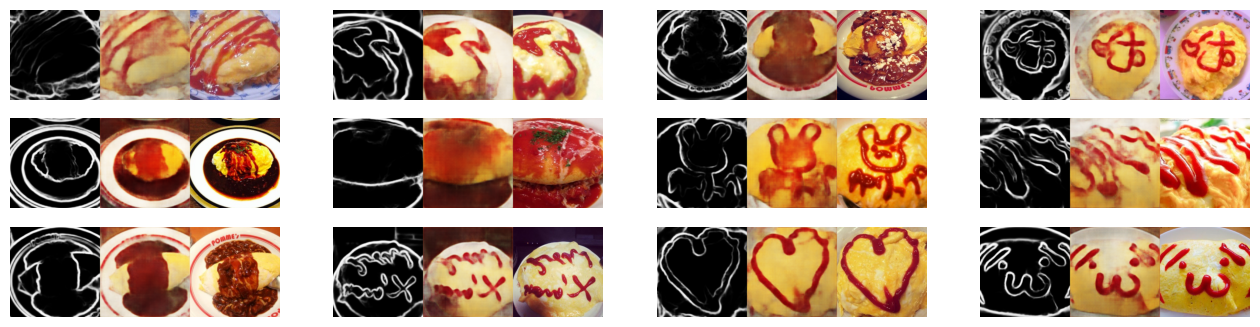

In [16]:
import time
start = time.time()
for epoch in range(1, opt.epochs + 1):
    for batch_num, data in enumerate(dataloader):
        batches_done = (epoch - 1) * len(dataloader) + batch_num
        model.train(data, batches_done)
        
        if batch_num % opt.log_interval == 0:
            tm = time.time() - start
            print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f} Time: {:.2f} sec ".format(
                epoch, batch_num, len(dataloader), model.lossD_real, model.lossG_GAN,tm))

    #if epoch % opt.save_data_interval == 0:
    #    model.save_model(epoch)

    if epoch % opt.save_image_interval == 0:
        model.save_image(epoch)

    model.update_learning_rate()
model.save_model(epoch-1)

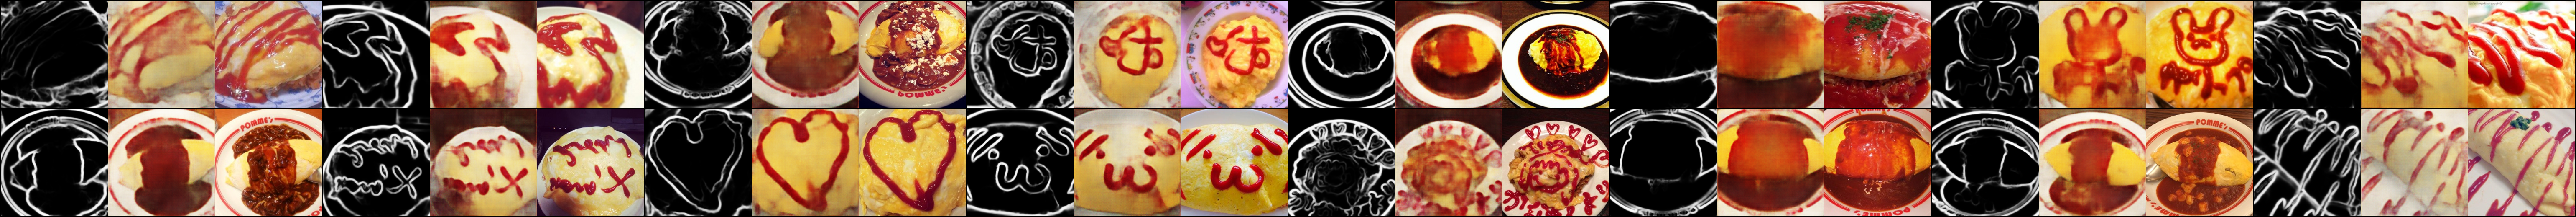

In [17]:
# 生成画像の確認 (入力画像、生成画像、正解画像)
from IPython.display import Image,display_png

image_name = '{}/pix2pix_epoch_{}.png'.format(outdir, opt.epochs)
display_png(Image(image_name))